In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [19]:
#---------------To arrange the points clockwise---------------
def order_points(pts):
    if len(pts) == 4:
        pts = np.array(pts)
        rect = np.zeros((4, 2), dtype = "int")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect[3] = pts[np.argmin(diff)]
        rect[1] = pts[np.argmax(diff)]
    else:
        pts = np.array(pts)
        rect = np.zeros((2, 2), dtype = "int")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
    return rect

#-----------To check ehether the points are neighbor-----------
def isClose(pt, seed):
    if abs(pt[0]-seed[0]) >= 16 or abs(pt[1]-seed[1]) >= 16:
        return False
    return True

#---------To check whether th epoint is a corner or not---------
def isCorner(point, vals):
    se = set()
    for j in range(point[0]-5,point[0]+5):
        for k in range(point[1]-5,point[1]+5):
            se = se.union({vals[j][k]})
            if len(se) == 3:
                return True
    # print(se)
    return False


def getCount(vals):
    li = [max(row) for row in vals]
    n = max(li)
    return int(n-2), 2


#-----------------To fetch the corners of the walls--------------
def findCorners(img, vals):
    img = cv2.resize(img, (320,320))

    h, w, c = img.shape

    imgGrey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgcanny = cv2.Canny(imgGrey, -150, 500)
    Epts = np.where(imgcanny != 0)
    c = cv2.cornerHarris(imgcanny, 5, 7, 0.07)
    # print(c.shape)
    k  = c>0.01*c.max()
    pts = np.where(k)
    # print(len(pts[0]))
    # print(type(c))

    Pts = [[pts[0][i], pts[1][i]] for i in range(len(pts[0]))]
    seeds, su, co, flag = [], [], [], False
    for pt in Pts:
        flag = True
        if len(seeds) == 0:
            x, y = pt[0], pt[1]
            seeds.append([x,y])
            su.append([x,y])
            co.append(1)
            continue
        for i in range(len(seeds)):
            if isClose(pt, seed=seeds[i]):
                flag = False
                su[i][0] = su[i][0] + pt[0]
                su[i][1] = su[i][1] + pt[1]
                co[i] += 1
                seeds[i][0] = su[i][0] // co[i]
                seeds[i][1] = su[i][1] // co[i]
                break
        if flag is True:
            x, y = pt[0], pt[1]
            seeds.append([x,y])
            su.append([x,y])
            co.append(1)


    outerPts = []




    # print(len(vals), len(vals[0]))
    current = vals[0][0]
    for i in range(1,len(vals[0])):
        if current != vals[0][i]:
            outerPts.append([0,i])
            current = vals[0][i]

    for i in range(1,len(vals)):
        if current != vals[i][319]:
            outerPts.append([i,319])
            current = vals[i][319]

    i = 319
    while(i >= 0):
        if current != vals[319][i]:
            # print(current, vals[319][i], i)
            outerPts.append([319,i])
            current = vals[319][i]
        i -= 1

    i = 319
    while(i >= 0):
        if current != vals[i][0]:
            outerPts.append([i,0])
            current = vals[i][0]
        i -= 1

    # print(outerPts)
    # print(order_points(outerPts))


    cornerPts = []
    # print(len(seeds))
    for i in range(len(seeds)):
        # print(seeds[i])
        if seeds[i][0] >= 5 and seeds[i][0] <= 295 and seeds[i][1] >= 5 and seeds[i][1] <= 295:
            if isCorner(seeds[i], vals):
                cornerPts.append(seeds[i])
                # cv2.circle(img, [seeds[i][1], seeds[i][0]], 5, [0,255,0], thickness=-5)
    
    return cornerPts, outerPts, img



def get_rectangles(cornerPts, outerPts, size):
        corn, outn = len(cornerPts), len(outerPts)
        walls = []
        if corn == 2:
            wall1 = [outerPts[0], cornerPts[0], cornerPts[1], outerPts[3]]
            wall2 = [cornerPts[0], outerPts[1], outerPts[2], cornerPts[1]]
            walls.append(wall1)
            walls.append(wall2)

        if corn == 4:
            wall1 = [outerPts[0], cornerPts[0], cornerPts[3], outerPts[3]]
            wall3 = [cornerPts[1], outerPts[1], outerPts[2], cornerPts[2]]
            wall2 = [cornerPts[0], cornerPts[1], cornerPts[2], cornerPts[3]]


def getRect(cornerPts, outerPts, size):
    corn, outn = len(cornerPts), len(outerPts)
    # print(corn)
    if outerPts[-1][1] == 0:
        if outerPts[-1][0] < outerPts[0][1]:
            i = len(outerPts) - 1
            while i > 0:
                temp = outerPts[i]
                outerPts[i] = outerPts[i-1]
                i -= 1
            outerPts[0] = temp

    if corn == 2:
        wall1 = [outerPts[0], cornerPts[0], cornerPts[1], outerPts[3]]
        wall2 = [cornerPts[0], outerPts[1], outerPts[2], cornerPts[1]]

        # ---------------For Wall 1----------------
        #The actual points to transorm will be a, corner1, corner2, b

        a, b = wall1[0], wall1[3]

        if wall1[0][1] != 0:
            # print(wall1[1], wall1[0])
            x = wall1[0][0] - ((wall1[1][0]-wall1[0][0]) / (wall1[1][1]-wall1[0][1])) * (wall1[0][1])
            a = [int(x),0]
        if wall1[3][1] != 0:
            x = wall1[2][0] - ((wall1[3][0]-wall1[2][0]) / (wall1[3][1]-wall1[2][1])) * (wall1[2][1])
            b = [int(x),0]

        # ---------------For Wall 2----------------
        #The actual points to transorm will be corner1, c, d, corner2

        c, d = wall2[1], wall2[2]

        if wall2[1][1] != size[1]-1:
            # print(wall2[1], wall2[0])
            x = wall2[0][0] - ((wall2[1][0]-wall2[0][0]) / (wall2[0][1]-wall2[1][1])) * (size[1]-1-wall2[0][1])
            c = [int(x),size[1]-1]
        if wall2[2][1] != size[1]-1:
            x = wall2[2][0] - ((wall2[3][0]-wall2[2][0]) / (wall2[2][1]-wall2[3][1])) * (size[1]-1-wall2[2][1])
            d = [int(x),size[1]-1]

        # print(a, b, c, d)
        return([a[::-1], wall1[1][::-1], wall1[2][::-1], b[::-1]], [wall2[0][::-1], c[::-1], d[::-1], wall2[3][::-1]])
    
    if corn == 4:
        wall1 = [outerPts[0], cornerPts[0], cornerPts[3], outerPts[3]]
        wall3 = [cornerPts[1], outerPts[1], outerPts[2], cornerPts[2]]
        wall2 = [cornerPts[0], cornerPts[1], cornerPts[2], cornerPts[3]]

        # ---------------For Wall 1----------------
        #The actual points to transorm will be a, corner1, corner2, b

        a, b = wall1[0], wall1[3]

        if wall1[0][1] != 0:
            # print(wall1[1], wall1[0])
            x = wall1[0][0] - ((wall1[1][0]-wall1[0][0]) / (wall1[1][1]-wall1[0][1])) * (wall1[0][1])
            a = [int(x),0]
        if wall1[3][1] != 0:
            x = wall1[2][0] - ((wall1[3][0]-wall1[2][0]) / (wall1[3][1]-wall1[2][1])) * (wall1[2][1])
            b = [int(x),0]

        # ---------------For Wall 3----------------
        #The actual points to transorm will be corner1, c, d, corner2

        c, d = wall3[1], wall3[2]

        if wall3[1][1] != size[1]-1:
            # print(wall3[1], wall3[0])
            x = wall3[0][0] - ((wall3[1][0]-wall3[0][0]) / (wall3[0][1]-wall3[1][1])) * (size[1]-1-wall3[0][1])
            c = [int(x),size[1]-1]
        if wall3[2][1] != size[1]-1:
            x = wall3[2][0] - ((wall3[3][0]-wall3[2][0]) / (wall3[2][1]-wall3[3][1])) * (size[1]-1-wall3[2][1])
            d = [int(x),size[1]-1]

        # print(a, b, c, d)
        return([a[::-1], wall1[1][::-1], wall1[2][::-1], b[::-1]], [wall2[0][::-1], wall2[1][::-1], wall2[2][::-1], wall2[3][::-1]], [wall3[0][::-1], c[::-1], d[::-1], wall3[3][::-1]])


In [26]:

img = cv2.imread("../inputs/outputs/img6.jpeg")
width, height, ch = img.shape
# img = cv2.imread("D:\\EdgeDownload\\3Walls.jpeg")

with open("../inputs/outputs/img6.txt", 'r') as file:
    lines = file.readlines()
vals = []
for line in lines:
    li = list(map(eval, line.split()))
    vals.append(li)
# print(order_points(cornerPts))
# print(getCount(vals=vals))


cornerPts, outerPts, img1 = findCorners(img, vals)

originalCornerPts, originalOuterPts = [], []

for pt in cornerPts:
    originalCornerPts.append([(pt[0]/320)*width, (pt[1]/320)*height])
    # cv2.circle(img1, [pt[1], pt[0]], 5, [0,255,0], thickness=-5)

for pt in outerPts:
    originalOuterPts.append([(pt[0]/320)*width, (pt[1]/320)*height])
    # cv2.circle(img1, [pt[1], pt[0]], 5, [0,255,0], thickness=-5)

# for pt in originalCornerPts:
#     cv2.circle(img, [int(pt[1]), int(pt[0])], 15, [0,255,0], thickness=-15)

# for pt in originalOuterPts:
#     cv2.circle(img, [int(pt[1]), int(pt[0])], 15, [0,255,0], thickness=-15)

rectangles = getRect(cornerPts=order_points(cornerPts), outerPts=order_points(outerPts), size=[320,320])

# design = cv2.imread("../inputs/products/Wallpapers/3_flower wallpaper anthea by Parato texture-seamless.jpg")
# design1 = cv2.imread("../inputs/products/Wallpapers/3_flower wallpaper anthea by Parato texture-seamless.jpg")
# design.resize((320,320))
# dh, dw = design.shape
# design1.resize(img.shape)
# odh, odw, ch = design1.shape

# # design = design.reshape([h, w, c])
# # matrix = cv2.getPerspectiveTransform(np.float32([[0, 0], [0,dh], [dw,dh], [dw,0]]), np.float32([first[:2], second[:2], fourth[:2],  third[:2]]))
# for i in range(len(rectangles)):
#     matrix = cv2.getPerspectiveTransform(np.float32([[0, 0], [0,dh], [dw,dh], [dw,0]]), np.float32([rectangles[i]]))
#     result = cv2.warpPerspective(design, matrix, [dw, dh])
#     # cv2.imshow('wall'+str(i), result)


originalRectangles = []

originalRectangles = getRect(cornerPts=order_points(originalCornerPts), outerPts=order_points(originalOuterPts), size=img.shape)

# finalRect = np.zeros_like(img)
# for i in range(len(originalRectangles)):
#     matrix = cv2.getPerspectiveTransform(np.float32([[0, 0], [0,odh], [odw,odh], [odw,0]]), np.float32([originalRectangles[i]]))
#     result = cv2.warpPerspective(design1, matrix, [odw, odh])
#     finalRect = cv2.bitwise_or(finalRect, result)
#     # cv2.imshow('wall'+str(i), result)


In [27]:
for i in originalRectangles:
    print(i)

[array([ 0, 97]), array([590, 296]), array([585, 738]), array([   0, 1046])]
[array([590, 296]), array([1160,  281]), array([1130,  772]), array([585, 738])]
[array([1160,  281]), [1599, -255], [1599, 1655], array([1130,  772])]


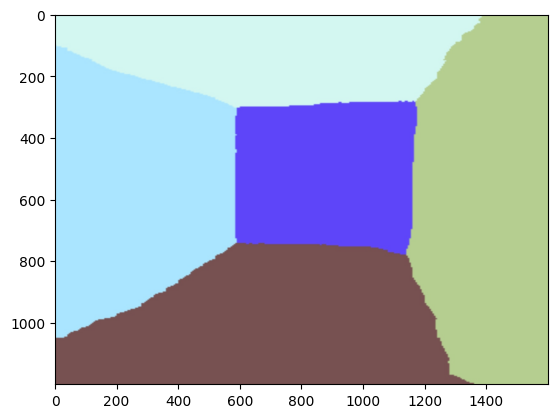

In [6]:
plt.imshow(img)